In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

from modeling import *

In [2]:
LINEWIDTH = 5
MARKERSIZE = 14
FONTSIZE = 32
LEGEND_FONTSIZE = 26
plt.rcParams["font.family"] = "Times New Roman"
impact_unit_map = {
    'AP': 'kg SO$_2$ eq',
    'EP': 'kg PO$_4^{3-}$ eq',
    'FETox': 'CTUe',
}

# Recycling

The old recylcing impact number is problematic in that the modeling is wrong and the data source cannot be verified.

## New model

$$ Impact = M [R \cdot F_{rec} + I \cdot(F_{inc}+p_{ash}F_{ash}) + L\cdot F_{land}]$$
where
- M: device in kg,
- R,I,L:  fractions to recycle, incinerate, landfill (R + I + L = 1),
- $p_{ash}$: kg ash per kg incinerated feed
- F_rec, F_inc, F_ash, F_land: the category-specific factors. F_rec is net impact after credit.

However, no reliable sources give a handy number on these categories for WEEE / metal mix. For this reason, I'm using a fallback method, relying on Fairphone 5's LCA reports which have a dedicated section on EOL.

# Embodied alltogether

### Selected Devices

- CPU
    + 2018(Q4) AMD EPYC 7571 on AWS M5a
    + 2019 AMD EPYC 7B12 on GCP N2d (us-central1)
    + 2021 AMD EPYC 7443 - local L40
    + 2022(Q4) AMD EPYC 9B14 (9654) on GCP C3d
    + (Substitute) 2023 Xeon Platinum 8480+ - Gautschi

- GPU: T4, V100, L40, A100 (40G/80G), H100

- Memory & Storage: Follow VM specs on GCP


In [3]:
cpu_specs_list = [epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs]
device_impacts = []
for cpu_specs in cpu_specs_list:
    impacts = calculate_total_impact(cpu_specs)
    device_impacts.append({
        'component_type': cpu_specs['component_type'],
        'name': cpu_specs['name'],
        'production_year': cpu_specs['production_year'],
        'impact_breakdown': impacts
    })
gpu_specs_list = [t4_specs, v100_specs, l40_specs, a100_40g_specs, h100_specs]
for gpu_specs in gpu_specs_list:
    impacts = calculate_total_impact(gpu_specs)
    device_impacts.append({
        'component_type': gpu_specs['component_type'],
        'name': gpu_specs['name'],
        'production_year': gpu_specs['production_year'],
        'impact_breakdown': impacts
    })

# Extract CPU and GPU data and their total midpoint impacts
cpu_data = []
gpu_data = []

for device in device_impacts:
    impacts = device['impact_breakdown']['total']['midpoint']
    if device['component_type'] == 'CPU':
        cpu_data.append({
            'name': device['name'],
            **impacts
        })
    else:
        gpu_data.append({
            'name': device['name'],
            **impacts
        })

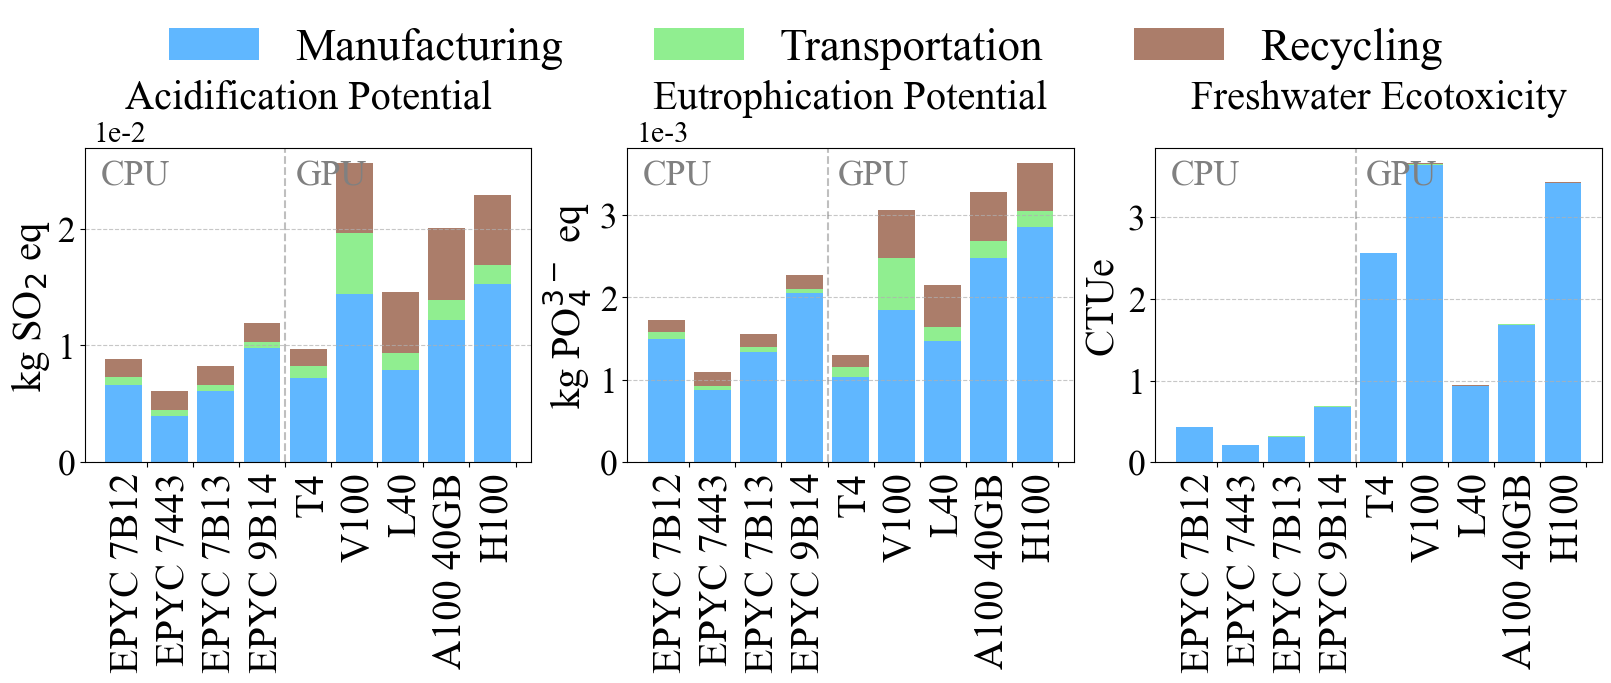

In [4]:
# Create figure and axis objects
from matplotlib.ticker import ScalarFormatter


fig = plt.figure(constrained_layout=True, figsize=(16,6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Colors for different stages
colors = ['#60B7FF', 'lightgreen', '#AB7D6A']
stages = ['manufacturing', 'transportation', 'recycling']

# Impact types
impacts = ['AP', 'EP', 'FETox']
titles = ['Acidification Potential', 'Eutrophication Potential', 'Freshwater Ecotoxicity']

# Extract data for plotting
devices = ['EPYC 7B12', 'EPYC 7443', 'EPYC 7B13', 'EPYC 9B14', 'T4', 'V100', 'L40', 'A100 40GB', 'H100']
stage_data = {impact: {stage: [] for stage in stages} for impact in impacts}

for device in device_impacts:
    for impact in impacts:
        for stage in stages:
            stage_data[impact][stage].append(device['impact_breakdown'][stage]['midpoint'][impact])

# Create stacked bars for each impact type
for idx, (impact, title) in enumerate(zip(impacts, titles)):
    ax = axes[idx]
    bottom = np.zeros(len(devices))
    
    for stage, color in zip(stages, colors):
        values = stage_data[impact][stage]
        if idx == 0:
            ax.bar(range(len(devices)), values, bottom=bottom, label=stage.capitalize(), 
               color=color, width=0.8)
        else:
            ax.bar(range(len(devices)), values, bottom=bottom, color=color, width=0.8)
        bottom += np.array(values)
    
    # Add dividing line between CPUs and GPUs
    ax.axvline(x=len(cpu_data)-0.5, color='gray', linestyle='--', alpha=0.5)
    ax.text(x=0.25, y=max(bottom)*0.9, s='CPU', ha='center', va='bottom', fontsize=FONTSIZE/1.25, color='gray')
    ax.text(x=len(cpu_data)+0.5, y=max(bottom)*0.9, s='GPU', ha='center', va='bottom', fontsize=FONTSIZE/1.25, color='gray')
    
    # Customize the plot
    ax.set_title(title, fontsize=FONTSIZE/1.1,y=1.1)
    ax.set_ylabel(f'{impact_unit_map[impact]}', fontsize=FONTSIZE/1.1)
    ax.tick_params(axis='y', labelsize=FONTSIZE/1.25)
    
    # Set x-ticks and labels
    ax.set_xticks(np.arange(len(devices))+0.5)
    ax.set_xticklabels(devices, rotation=90, ha='right',fontsize=FONTSIZE/1.1)

    if idx==0:
        # ax.set_ylim(0, 4e-3)
        ax.set_yticks([0, 1e-2, 2e-2])
        ax.set_yticklabels(['0', '1', '2'])
        ax.text(0.02, 1.02, '1e-2', fontsize=FONTSIZE/1.5, 
                 transform=ax.transAxes)

    if idx==1:
        # ax.set_ylim(0, 4e-3)
        ax.set_yticks([0, 1e-3, 2e-3, 3e-3])
        ax.set_yticklabels(['0', '1', '2', '3'])
        ax.text(0.02, 1.02, '1e-3', fontsize=FONTSIZE/1.5, 
                 transform=ax.transAxes)
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add single legend at the top
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fontsize=LEGEND_FONTSIZE*1.25,frameon=False)

# Adjust subplot parameters to give specified padding
# plt.subplots_adjust(top=0.85)
# plt.savefig('figures/mebi_logic_breakdown.pdf', bbox_inches='tight')
plt.show()


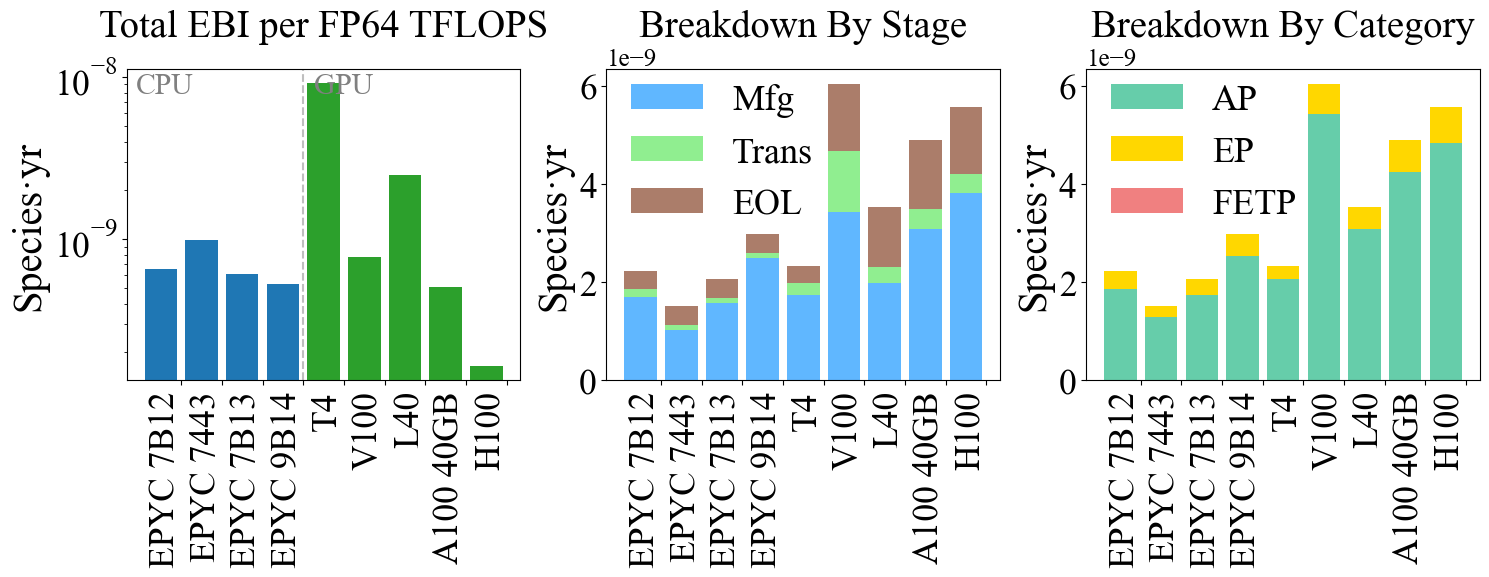

In [5]:
# Create three subplots side by side
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 6))
# fig.suptitle('Endpoint EBI Analysis', y=0.98, fontsize=FONTSIZE, x=0.52)

# Get device names
devices = ['EPYC 7B12', 'EPYC 7443', 'EPYC 7B13', 'EPYC 9B14', 'T4', 'V100', 'L40', 'A100 40GB', 'H100']
n_devices = len(devices)

# Calculate per TFLOPS impacts
tflops_data = np.zeros(n_devices)
for i, device in enumerate(device_impacts):
    if device['component_type'] == 'CPU':
        for cpu_spec in [epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs]:
            if cpu_spec['name'] == device['name']:
                tflops = cpu_spec['peak_tflops']
                break
    else:
        for gpu_spec in [t4_specs, v100_specs, l40_specs, a100_40g_specs, h100_specs]:
            if gpu_spec['name'] == device['name']:
                tflops = gpu_spec['fp64_tflops']
                break
    
    total_endpoint = sum(device['impact_breakdown']['total']['endpoint'].values())
    tflops_data[i] = total_endpoint / tflops

# Plot per TFLOPS data
colors = ['tab:blue' if i < len([epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs]) else 'tab:green' 
          for i in range(n_devices)]
ax0.bar(range(n_devices), tflops_data, color=colors, width=0.8)

# Add dividing line between CPUs and GPUs
ax0.axvline(x=len([epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs])-0.5, color='gray', linestyle='--', alpha=0.5)
ax0.text(x=0.1, y=max(tflops_data)*0.8, s='CPU', ha='center', va='bottom', fontsize=FONTSIZE/1.5, color='gray')
ax0.text(x=len([epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs])+0.5, y=max(tflops_data)*0.8, s='GPU', ha='center', va='bottom', fontsize=FONTSIZE/1.5, color='gray')

# Customize the plot
ax0.set_xticks(np.arange(n_devices)+0.5)
ax0.set_xticklabels(devices, rotation=90, ha='right', fontsize=FONTSIZE/1.25)
ax0.set_ylabel('Species·yr', fontsize=FONTSIZE/1.1)
ax0.tick_params(axis='y', labelsize=FONTSIZE/1.25)
ax0.set_title('Total EBI per FP64 TFLOPS', fontsize=FONTSIZE/1.15, y=1.08)
ax0.set_yscale('log')

# Prepare data for lifecycle stage and midpoint category breakdowns
lifecycle_data = np.zeros((n_devices, 3))  # 3 lifecycle stages
midpoint_data = np.zeros((n_devices, 3))  # 3 impact categories

for i, device in enumerate(device_impacts):
    lifecycle_data[i, 0] = sum(device['impact_breakdown']['manufacturing']['endpoint'].values())
    lifecycle_data[i, 1] = sum(device['impact_breakdown']['transportation']['endpoint'].values())
    lifecycle_data[i, 2] = sum(device['impact_breakdown']['recycling']['endpoint'].values())
    
    midpoint_data[i, 0] = device['impact_breakdown']['total']['endpoint']['AP_to_endpoint']
    midpoint_data[i, 1] = device['impact_breakdown']['total']['endpoint']['EP_to_endpoint']
    midpoint_data[i, 2] = device['impact_breakdown']['total']['endpoint']['FETox_to_endpoint']

# Colors for the stacked bars
lifecycle_colors = ['#60B7FF', 'lightgreen', '#AB7D6A']
midpoint_colors = ['mediumaquamarine','gold', 'lightcoral', ]

# Plot lifecycle stage breakdown
bottom = np.zeros(n_devices)
for i in range(3):
    ax1.bar(range(n_devices), lifecycle_data[:, i], bottom=bottom, 
            color=lifecycle_colors[i], label=['Mfg', 'Trans', 'EOL'][i],
            width=0.8)
    bottom += lifecycle_data[:, i]

# Plot midpoint category breakdown
bottom = np.zeros(n_devices)
for i in range(3):
    ax2.bar(range(n_devices), midpoint_data[:, i], bottom=bottom, 
            color=midpoint_colors[i], label=['AP', 'EP', 'FETP'][i],
            width=0.8)
    bottom += midpoint_data[:, i]

# Customize the plots
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(n_devices)+0.5)
    ax.set_xticklabels(devices, rotation=90, ha='right', fontsize=FONTSIZE/1.25)
    ax.set_ylabel('Species·yr', fontsize=FONTSIZE/1.1)
    ax.tick_params(axis='y', labelsize=FONTSIZE/1.25)

ax1.set_title('Breakdown By Stage', fontsize=FONTSIZE/1.15, y=1.08)
ax2.set_title('Breakdown By Category', fontsize=FONTSIZE/1.15, y=1.08)

# Add legends
ax1.legend(fontsize=LEGEND_FONTSIZE, frameon=False, loc='upper left', bbox_to_anchor=(-0.02, 1.06))
ax1.yaxis.get_offset_text().set_fontsize(18)
ax2.legend(fontsize=LEGEND_FONTSIZE, frameon=False, loc='upper left', bbox_to_anchor=(-0.02, 1.06))
ax2.yaxis.get_offset_text().set_fontsize(18)

plt.tight_layout()
# plt.savefig('figures/ebi_logic_breakdown.pdf', bbox_inches='tight')
plt.show()

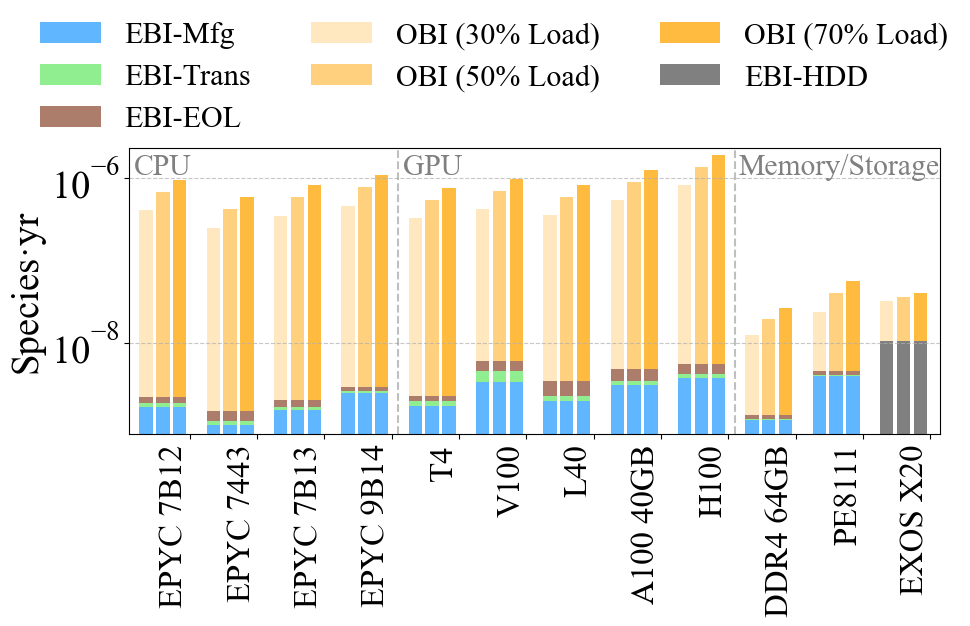

In [6]:
# Load scenarios
load_scenarios = [0.3, 0.5, 0.7]
cpu_specs_list = [epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs]
device_impacts = []
for cpu_specs in cpu_specs_list:
    impacts = calculate_total_impact(cpu_specs)
    device_impacts.append({
        'component_type': cpu_specs['component_type'],
        'name': cpu_specs['name'],
        'production_year': cpu_specs['production_year'],
        'impact_breakdown': impacts
    })

gpu_specs_list = [t4_specs, v100_specs, l40_specs, a100_40g_specs, h100_specs]
for gpu_specs in gpu_specs_list:
    impacts = calculate_total_impact(gpu_specs)
    device_impacts.append({
        'component_type': gpu_specs['component_type'],
        'name': gpu_specs['name'],
        'production_year': gpu_specs['production_year'],
        'impact_breakdown': impacts
    })

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 7))

# Get device names
devices = ['EPYC 7B12', 'EPYC 7443', 'EPYC 7B13', 'EPYC 9B14', 'T4', 'V100', 'L40', 'A100 40GB', 'H100', 'DDR4 64GB', 'PE8111', 'EXOS X20']
n_devices = len(devices)
ddr4_specs = {'name': 'DDR4 64GB', 'production_year': 2020, 'idle_power':64*40/1031, 'peak_power': 8, 'mass':45.4, 'component_type':'DRAM', 'capacity': 64, 'distance':distance['default']}
pe8111_specs = {'name': 'PE8111', 'production_year': 2023, 'idle_power':5, 'peak_power': 20, 'mass':334, 'component_type':'SSD', 'capacity': 15.36*1000, 'distance':distance['default']}
exos_specs = {'name': 'EXOS X20', 'production_year': 2023, 'idle_power':5.6, 'peak_power': 9.3, 'mass':773, 'component_type':'HDD', 'capacity': 20*1000, 'distance':distance['default']}
for device in [ddr4_specs, pe8111_specs, exos_specs]:
    impacts = calculate_total_impact(device)
    device_impacts.append({
              'name': device['name'],
              'component_type': device['component_type'],
              'production_year': device['production_year'],
              'impact_breakdown': impacts,
    })

# Colors for the stacked bars
lifecycle_colors = ['#60B7FF', 'lightgreen', '#AB7D6A', 'orange']  # Added color for operation

# For storing maximum values to set y-axis limits
max_lifecycle = 0

# Plot for each load scenario
for load_idx, load in enumerate(load_scenarios):
       # Calculate operational impacts
       operational_endpoint_impacts = []
       for device_spec in [epyc_7b12_specs, epyc_7443_specs, epyc_7b13_specs, epyc_9b14_specs,
                                      t4_specs, v100_specs, l40_specs, a100_40g_specs, h100_specs, ddr4_specs, pe8111_specs, exos_specs]:
              op_impact = calculate_operational_impacts(device_spec, load)
              operational_endpoint_impacts.append(midpoint_to_endpoint(op_impact))

       # Lifecycle stage breakdown
       bottom = np.zeros(n_devices)
       for i, device in enumerate(device_impacts[:-1]):
              # Manufacturing
              manufacturing_sum = sum(device['impact_breakdown']['manufacturing']['endpoint'].values())
              ax.bar(i + load_idx*0.25, manufacturing_sum, bottom=bottom[i], 
                        color=lifecycle_colors[0], width=0.2, 
                        label='EBI-Mfg' if i == 0 and load_idx == 0 else "")
              bottom[i] += manufacturing_sum
              
              # Transportation
              transport_sum = sum(device['impact_breakdown']['transportation']['endpoint'].values())
              ax.bar(i + load_idx*0.25, transport_sum, bottom=bottom[i], 
                        color=lifecycle_colors[1], width=0.2,
                        label='EBI-Trans' if i == 0 and load_idx == 0 else "")
              bottom[i] += transport_sum
              
              # Recycling
              recycling_sum = sum(device['impact_breakdown']['recycling']['endpoint'].values())
              ax.bar(i + load_idx*0.25, recycling_sum, bottom=bottom[i], 
                        color=lifecycle_colors[2], width=0.2,
                        label='EBI-EOL' if i == 0 and load_idx == 0 else "")
              bottom[i] += recycling_sum
              
              # Operation
              operation_sum = sum(operational_endpoint_impacts[i].values())
              ax.bar(i + load_idx*0.25, operation_sum, bottom=bottom[i], 
                        color=lifecycle_colors[3], width=0.2, alpha=(load_idx+1)*0.25,
                        label=f'OBI ({int(load*100)}% Load)' if i == 0 else "")
              bottom[i] += operation_sum
              
              max_lifecycle = max(max_lifecycle, bottom[i])

       i = n_devices - 1
       device = device_impacts[-1]
       # Manufacturing
       manufacturing_sum = sum(device['impact_breakdown']['manufacturing']['endpoint'].values())
       ax.bar(i + load_idx*0.25, manufacturing_sum, bottom=bottom[i], 
                 color='gray', width=0.2, 
                 label='EBI-HDD' if load_idx == 2 else "")
       
       bottom[i] += manufacturing_sum
       # Operation
       operation_sum = sum(operational_endpoint_impacts[i].values())
       ax.bar(i + load_idx*0.25, operation_sum, bottom=bottom[i], 
                 color=lifecycle_colors[3], width=0.2, alpha=(load_idx+1)*0.25,
                 label=f'Operation ({int(load*100)}% Load)' if i == 0 else "")

# Customize the plot
ax.set_xticks(np.arange(n_devices) + 0.65)
ax.set_xticklabels(devices, rotation=90, ha='right', fontsize=FONTSIZE/1.35)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.axvline(x=3.75, color='gray', linestyle='--', alpha=0.5)
ax.text(x=0.25, y=max_lifecycle*0.5, s='CPU', ha='center', va='bottom', fontsize=FONTSIZE/1.5, color='gray')
ax.text(x=4.25, y=max_lifecycle*0.5, s='GPU', ha='center', va='bottom', fontsize=FONTSIZE/1.5, color='gray')
ax.axvline(x=8.75, color='gray', linestyle='--', alpha=0.5)
ax.text(x=8.8, y=max_lifecycle*0.5, s='Memory/Storage', ha='left', va='bottom', fontsize=FONTSIZE/1.5, color='gray')

ax.set_ylabel('Species·yr', fontsize=FONTSIZE/1.15)
ax.tick_params(axis='y', labelsize=FONTSIZE/1.15)
ax.set_yscale('log')
ax.set_xlim(-0.25, n_devices - 0.2)
ax.set_ylim(8e-10,2.3e-6)

# Add title with increased padding
# ax.set_title('Biodiversity Impact by Lifecycle Stages', fontsize=FONTSIZE, pad=50,y=1.08)

# Add legend with better spacing
legend = ax.legend(ncol=3, fontsize=LEGEND_FONTSIZE/1.2, 
                              bbox_to_anchor=(0.45, 1.25), 
                              loc='center', 
                              frameon=False)

plt.tight_layout()
# plt.savefig('figures/logic_breakdown_lifecycle.pdf', bbox_inches='tight')
plt.show()


Year: 2023, DRAM: 9.25e-09, SSD: 2.86e-10, HDD: 5.41e-10


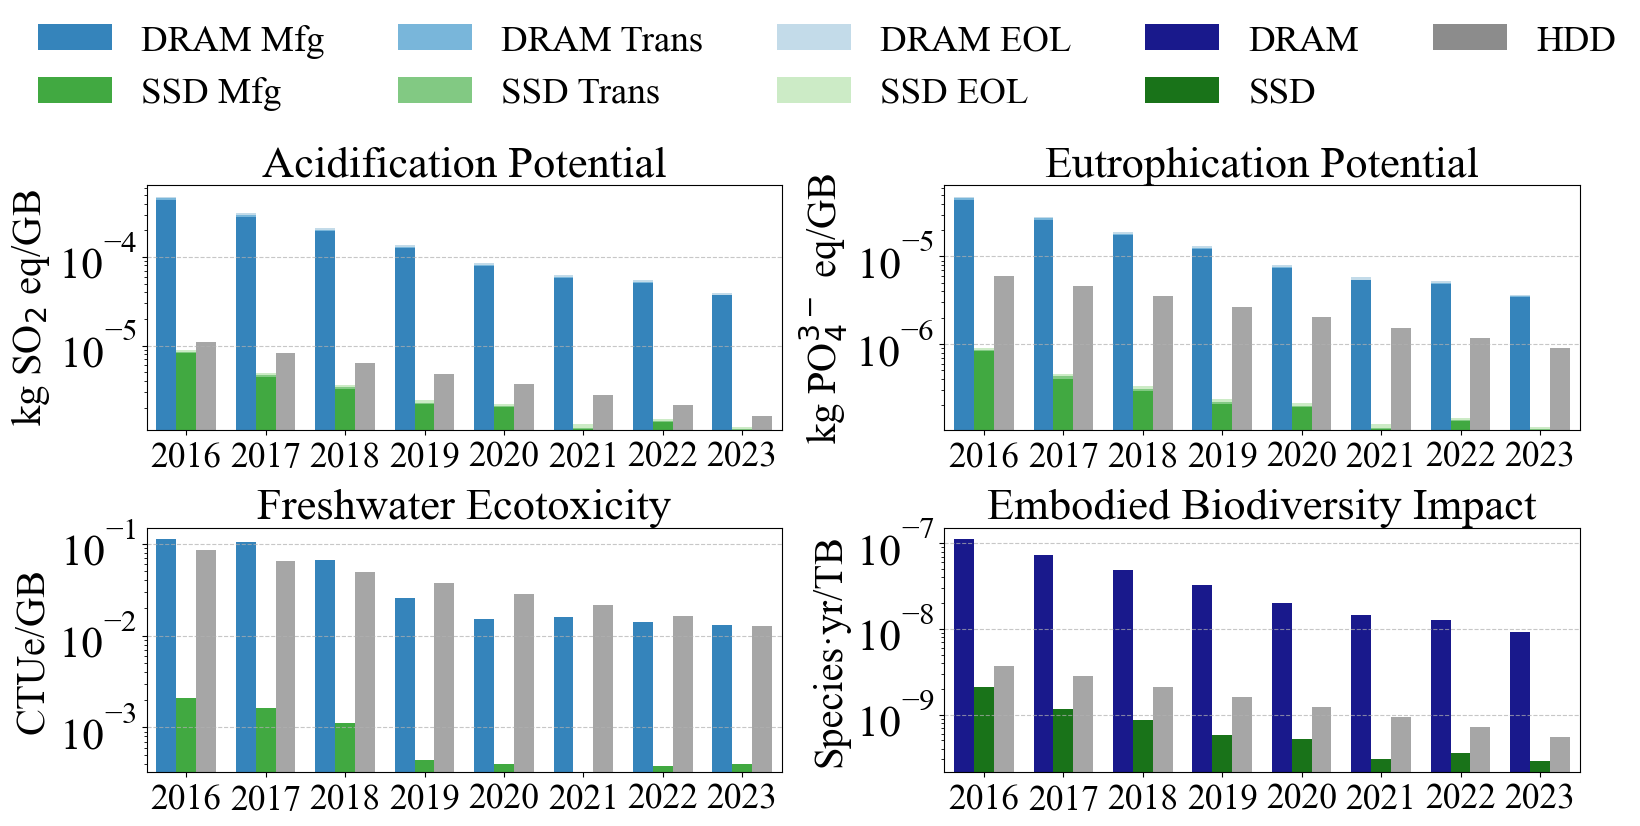

In [8]:
# Create figure and axis objects for four impact categories (three midpoints + one endpoint)
fig, axes = plt.subplots(2, 2, figsize=(16,7))  # Changed from 1x4 to 2x2 layout
axes = axes.flatten()  # Flatten to make indexing easier
# fig.suptitle('Midpoint and Endpoint EBI for Memory and Storage', y=1.06, fontsize=FONTSIZE)

# Years range
years = range(2016, 2024)

# Initialize dictionaries to store impacts
dram_impacts = {year: {'manufacturing': {}, 'transportation': {}, 'recycling': {}} for year in years}
ssd_impacts = {year: {'manufacturing': {}, 'transportation': {}, 'recycling': {}} for year in years}
hdd_impacts = {year: {} for year in years}

# Calculate impacts for each year and storage type
for year in years:
    # Calculate DRAM impacts
    dram_result = calculate_storage_manufacturing_impacts('DRAM', year, 1)  # 1GB
    dram_mass = df_storage_weight_density['DRAM_g/GB'].loc[str(year)]
    transport_impact = calculate_transport_impact(dram_mass, distance['default'], 'g', year)
    recycling_impact = calculate_recycling_impact(dram_mass, 'g')
    
    dram_impacts[year]['manufacturing'] = dram_result
    dram_impacts[year]['transportation'] = transport_impact
    dram_impacts[year]['recycling'] = recycling_impact

    # Calculate SSD impacts
    ssd_result = calculate_storage_manufacturing_impacts('SSD', year, 1)  # 1GB
    ssd_mass = df_storage_weight_density['SSD_g/GB'].loc[str(year)]
    transport_impact = calculate_transport_impact(ssd_mass, distance['default'], 'g', year)
    recycling_impact = calculate_recycling_impact(ssd_mass, 'g')
    
    ssd_impacts[year]['manufacturing'] = ssd_result
    ssd_impacts[year]['transportation'] = transport_impact
    ssd_impacts[year]['recycling'] = recycling_impact

    # Calculate HDD impacts (single value per year)
    hdd_impacts[year] = calculate_storage_manufacturing_impacts('HDD', year, 1)  # 1GB

# Prepare data for plotting
impacts = ['AP', 'EP', 'FETox']
stages = ['manufacturing', 'transportation', 'recycling']
legend_stages =['Mfg','Trans','EOL']
colors = ['lightblue', 'lightgreen', 'salmon']
titles = ['Acidification Potential', 'Eutrophication Potential', 'Freshwater Ecotoxicity', 'Embodied Biodiversity Impact']

# Create stacked bar plots for midpoint impacts
for idx, (impact, title) in enumerate(zip(impacts, titles[:3])):
    ax = axes[idx]
    x = np.arange(len(years))
    width = 0.25  # Reduced width to accommodate HDD bars
    
    # Color series for DRAM and SSD lifecycle stages
    dram_colors = ['#1f77b4', '#6baed6', '#bdd7e7']  # Blue series
    ssd_colors = ['#2ca02c', '#74c476', '#c7e9c0']   # Green series
    
    # DRAM bars
    bottom_dram = np.zeros(len(years))
    for stage, color in zip(stages, dram_colors):
        values = [dram_impacts[year][stage][impact] for year in years]
        ax.bar(x - width, values, width, bottom=bottom_dram, 
               color=color, alpha=0.9, label=f'DRAM {stage}' if idx == 0 else "")
        bottom_dram += np.array(values)
    
    # SSD bars
    bottom_ssd = np.zeros(len(years))
    for stage, color in zip(stages, ssd_colors):
        values = [ssd_impacts[year][stage][impact] for year in years]
        ax.bar(x + 0, values, width, bottom=bottom_ssd,
               color=color, alpha=0.9, label=f'SSD {stage}' if idx == 0 else "")
        bottom_ssd += np.array(values)
    
    # HDD bars (non-stacked)
    hdd_values = [hdd_impacts[year][impact] for year in years]
    ax.bar(x + width, hdd_values, width, color='gray', alpha=0.7,
           label='HDD' if idx == 0 else "")
    
    ax.set_title(title, fontsize=FONTSIZE)
    # ax.set_xlabel('Year', fontsize=FONTSIZE/1.5)
    ax.set_ylabel(f'{impact_unit_map[impact]}/GB', fontsize=FONTSIZE/1.1)
    ax.tick_params(axis='x', labelsize=FONTSIZE/1.25)
    ax.set_xlim(-0.5, len(years) - 0.5)
    ax.tick_params(axis='y', labelsize=FONTSIZE)
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.set_yscale('log')

ax = axes[3]
x = np.arange(len(years))
dram_totals, ssd_totals, hdd_totals = [], [], []

# Calculate endpoint impacts (now per TB)
for year in years:
    # DRAM total endpoint (sum all stages and convert to per TB)
    dram_total = 0
    for stage in stages:
        stage_midpoints = {impact: dram_impacts[year][stage][impact] for impact in impacts}
        dram_total += sum(midpoint_to_endpoint(stage_midpoints).values())
    dram_total *= 1024  # Convert from per GB to per TB
    dram_totals.append(dram_total)
    
    # SSD total endpoint (sum all stages and convert to per TB)
    ssd_total = 0
    for stage in stages:
        stage_midpoints = {impact: ssd_impacts[year][stage][impact] for impact in impacts}
        ssd_total += sum(midpoint_to_endpoint(stage_midpoints).values())
    ssd_total *= 1024  # Convert from per GB to per TB
    ssd_totals.append(ssd_total)
    
    # HDD endpoint (convert to per TB)
    hdd_total = sum(midpoint_to_endpoint(hdd_impacts[year]).values()) * 1024
    hdd_totals.append(hdd_total)

    # Plot bars with consistent colors
ax.bar(x - width, dram_totals, width, color='navy', alpha=0.9,
        label='DRAM' if year == years[0] else "")
ax.bar(x, ssd_totals, width, color='darkgreen', alpha=0.9,
        label='SSD' if year == years[0] else "")
ax.bar(x + width, hdd_totals, width, color='gray', alpha=0.7,
        label='HDD' if year == years[0] else "")
print(f"Year: {year}, DRAM: {dram_total:.2e}, SSD: {ssd_total:.2e}, HDD: {hdd_total:.2e}")

ax.set_title(titles[3], fontsize=FONTSIZE)
# ax.set_xlabel('Year', fontsize=FONTSIZE/1.5)
ax.set_ylabel('Species·yr/TB', fontsize=FONTSIZE/1.1)
ax.tick_params(axis='x', labelsize=FONTSIZE/1.25)
ax.tick_params(axis='y', labelsize=FONTSIZE)
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_xlim(-0.5, len(years) - 0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_yscale('log')

# Create legend elements for both device types and lifecycle stages
legend_elements = []

# Add lifecycle stage elements
for stage, c1, c2 in zip(legend_stages, dram_colors, ssd_colors):
    legend_elements.append(plt.Rectangle((0,0), 1, 1, facecolor=c1, alpha=0.9, label=f'DRAM {stage}'))
    legend_elements.append(plt.Rectangle((0,0), 1, 1, facecolor=c2, alpha=0.9, label=f'SSD {stage}'))

# Add device type elements
for color, label in zip(['navy', 'darkgreen', 'gray'], ['DRAM', 'SSD', 'HDD']):
    legend_elements.append(plt.Rectangle((0,0), 1, 1, facecolor=color, alpha=0.9, label=label))

fig.legend(handles=legend_elements,
          loc='upper center', 
          bbox_to_anchor=(0.52, 1.2),
          ncol=5, 
          frameon=False,
          fontsize=LEGEND_FONTSIZE*1.02)

plt.tight_layout()
# plt.savefig('figures/ebi_mem_storage.pdf', bbox_inches='tight')
plt.show()


In [9]:
# Server components specifications
server_specs = {
    'cpu': {
    'component_type': 'CPU',
    'name': 'AMD EPYC 7443',
    'net_weight': 220,
    'gross_weight': 500,
    'distance': distance['default'],
    'recycling_rate': 0.9,
    'inceneration_rate': 0.08,
    'landfill_rate': 0.02,
    'die_size_mm2': 81*4,  
    'technology_node_nm': 7, 
    'io_die_size_mm2': 416,  # No IO die for EPYC
    'io_die_technology_node_nm': 12,  
    'production_year': 2021,
    'TDP': 200,  # in watts
    'num_cores': 24,
    'num_threads': 48,
    'peak_tflops': 1.54,
},
    'memory': {
        'component_type': 'DRAM',
        'capacity': 528, # GB
        'production_year': 2022,
        'distance': distance['default'],
    },
    'gpus': l40_specs,
    'storage': [
        {
            'component_type': 'SSD',
            'capacity': 2000, # GB
            'production_year': 2023,
            'distance': distance['default'],
        },
        {
            'component_type': 'HDD',
            'capacity': 20000, # GB
            'production_year': 2023,
            'distance': distance['default'],
        }
    ]
}

# Calculate impacts for each component
impacts = {
    'CPU': calculate_total_impact(server_specs['cpu']),
    'GPU': calculate_total_impact(server_specs['gpus']),
    'Memory': calculate_total_impact(server_specs['memory']),
    'SSD': calculate_total_impact(server_specs['storage'][0]),
    'HDD': calculate_total_impact(server_specs['storage'][1])
}
components = list(impacts.keys())

# Multiply GPU impacts by 4 since we have 4 L40s
for category in impacts['GPU']['total']['midpoint']:
    impacts['GPU']['total']['midpoint'][category] *= 4

for category in impacts['GPU']['total']['endpoint']:
    impacts['GPU']['total']['endpoint'][category] *= 4

# Plot endpoint impacts
endpoint_data = []
for component in components:
    endpoint_value = sum(impacts[component]['total']['endpoint'].values())
    endpoint_data.append(endpoint_value)


# Print total impacts
total_midpoint = {
    'AP': sum(impacts[c]['total']['midpoint']['AP'] for c in components),
    'EP': sum(impacts[c]['total']['midpoint']['EP'] for c in components),
    'FETox': sum(impacts[c]['total']['midpoint']['FETox'] for c in components)
}
total_endpoint = sum(endpoint_data)

In [15]:
def calculate_impact_ratios(system_specs, impacts):
    """
    Calculate the impact ratio for each component in a system.
    
    Args:
        system_specs (dict): System specifications dictionary
        impacts (dict): Dictionary containing impact calculation results
    
    Returns:
        dict: Component names and their percentage contributions
    """
    # Calculate endpoint impacts for each component
    endpoint_impacts = {}
    total_impact = 0
    
    for component, impact in impacts.items():
        endpoint_value = sum(impact['total']['endpoint'].values())
        endpoint_impacts[component] = endpoint_value
        total_impact += endpoint_value
    
    # Calculate percentages
    percentages = {k: v/total_impact * 100 for k,v in endpoint_impacts.items()}
    
    # Use predefined order for components
    fixed_order = ['CPU','GPU', 'Memory','SSD','HDD']
    ordered_percentages = {component: percentages[component] for component in fixed_order}
    return ordered_percentages

def plot_system_impact_donuts(ratios_list, titles=None, figsize=(15, 5)):
    """
    Create multiple donut charts showing impact distribution.
    
    Args:
        ratios_list (list): List of dictionaries containing component ratios
        titles (list): List of subplot titles
        figsize (tuple): Figure size
    """
    n_plots = len(ratios_list)
    
    # Create figure
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    
    # Colors and other settings
    colors = ['#F89540','#E5ED1F',  '#1E90FF', '#663399', '#184787']
    
    
    # Create donut charts
    for idx, (ax, ratios) in enumerate(zip(axes, ratios_list)):
        components = list(ratios.keys())
        values = list(ratios.values())
        # Remove zero/nan values and corresponding components/colors
        plot_values = [v for v in values if v != 0 and not np.isnan(v)]
        plot_components = [c for i,c in enumerate(components) if values[i] != 0 and not np.isnan(values[i])]
        plot_colors = [colors[i] for i,c in enumerate(components) if values[i] != 0 and not np.isnan(values[i])]
        explode = [0.005] * len(plot_values)  # Slightly separate the wedges
        
        # Create donut chart
        wedges, texts, autotexts = ax.pie(plot_values,
                                         explode=explode,
                                        #  labels=components,
                                         colors=plot_colors,
                                         autopct=lambda pct: f'{pct:.0f}%',
                                         pctdistance=1.22,
                                         wedgeprops=dict(width=0.5, edgecolor='black', linewidth=1),
                                         startangle=90,
                                         )
        
        # Add center circle for donut
        centre_circle = plt.Circle((0,0), 0.70, fc='white', ec='black', linewidth=2)
        ax.add_artist(centre_circle)
        
        # Style the labels and percentage text
        plt.setp(autotexts, size=FONTSIZE/1.25)
        plt.setp(texts, size=FONTSIZE/1.25)
        
        # Add title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx], pad=20, fontsize=FONTSIZE/1.25, y=0.48, weight='bold')
        
        ax.axis('equal')
    
    # Add single legend for all subplots
    legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor=color, label=comp, edgecolor='black', linewidth=1)
                      for comp, color in zip(components, colors)]
    fig.legend(handles=legend_elements, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.15),
              ncol=len(components),
                frameon=False,
              fontsize=LEGEND_FONTSIZE*1.2)
    
    plt.tight_layout()
    return fig, axes


In [11]:
# Perlmutter specs:
# CPUs: 7B13: 1536+256+3072x2
# GPUs: A100 40GB: 4x1536; A100 80GB: 4x 256
# Memory: (1536+256)x256GB + 3072x512GB, year 2021
# Storage: 44PB all SSD, year 2021

a100_80g_specs = a100_40g_specs.copy()
a100_80g_specs['name'] = 'A100 80GB'
a100_80g_specs['hbm_capacity_GB'] = 80
a100_80g_specs['memory_bandwidth'] = 2039

# Perlmutter Phase 1+2
perlmutter_specs = {
    'cpu_nodes': {
        'system': 'CPU Only',
        'cpus': [epyc_7b13_specs]*3072,  # 3072 nodes with 1 CPU each 
        'ram_per_node': 512,  # GB
        'year': 2021
    },
    'gpu_nodes': {
        'system': 'GPU',  
        'gpus': [a100_80g_specs]*1024,  # 256 nodes with 4 A100 80GB each
        'gpus2': [a100_40g_specs]*6144,  # 1536 nodes with 4 A100 40GB each
        'cpus': [epyc_7b13_specs]*1792,  # One CPU per node
        'ram_per_node': 256,  # GB
        'year': 2021
    },
    'storage': {
        'type': 'SSD',
        'capacity': 44000000,  # GB (44PB) 
        'year': 2021
    }
}

# Calculate total impact
total_impact = {
    'AP': 0.0,
    'EP': 0.0, 
    'FETox': 0.0
}

# CPU nodes
for node in range(len(perlmutter_specs['cpu_nodes']['cpus'])):
    # CPU impact
    cpu_impact = calculate_total_impact(perlmutter_specs['cpu_nodes']['cpus'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += cpu_impact['total']['midpoint'][metric]
        
    # Memory impact
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': perlmutter_specs['cpu_nodes']['ram_per_node'],
        'production_year': perlmutter_specs['cpu_nodes']['year'],
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += memory_impact['total']['midpoint'][metric]

# GPU nodes
# First batch with A100 80GB
for node in range(len(perlmutter_specs['gpu_nodes']['gpus'])):
    # GPU impact (4 per node)
    gpu_impact = calculate_total_impact(perlmutter_specs['gpu_nodes']['gpus'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += gpu_impact['total']['midpoint'][metric] * 4

# Second batch with A100 40GB
for node in range(len(perlmutter_specs['gpu_nodes']['gpus2'])):
    # GPU impact (4 per node)
    gpu_impact = calculate_total_impact(perlmutter_specs['gpu_nodes']['gpus2'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += gpu_impact['total']['midpoint'][metric] * 4

# CPU and memory for all GPU nodes
for node in range(len(perlmutter_specs['gpu_nodes']['cpus'])):
    # CPU impact
    cpu_impact = calculate_total_impact(perlmutter_specs['gpu_nodes']['cpus'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += cpu_impact['total']['midpoint'][metric]
        
    # Memory impact
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': perlmutter_specs['gpu_nodes']['ram_per_node'],
        'production_year': perlmutter_specs['gpu_nodes']['year'],
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += memory_impact['total']['midpoint'][metric]

# Storage impact
storage_specs = {
    'component_type': perlmutter_specs['storage']['type'],
    'capacity': perlmutter_specs['storage']['capacity'],
    'production_year': perlmutter_specs['storage']['year'],
    'distance': distance['default']
}
storage_impact = calculate_total_impact(storage_specs)
for metric in ['AP', 'EP', 'FETox']:
    total_impact[metric] += storage_impact['total']['midpoint'][metric]

print("\nTotal System Impacts:")
print(f"AP: {total_impact['AP']:.2e} {impact_unit_map['AP']}")
print(f"EP: {total_impact['EP']:.2e} {impact_unit_map['EP']}")  
print(f"FETox: {total_impact['FETox']:.2e} {impact_unit_map['FETox']}")

perl_endpoint_impacts = midpoint_to_endpoint(total_impact)
print(f"\nTotal endpoint impact: {sum(perl_endpoint_impacts.values()):.2e} species·yr")


Total System Impacts:
AP: 8.26e+02 kg SO$_2$ eq
EP: 1.21e+02 kg PO$_4^{3-}$ eq
FETox: 1.02e+05 CTUe

Total endpoint impact: 2.00e-04 species·yr


In [12]:
def calculate_perlmutter_annual_impact(load_ratio=0.7):
    """
    Calculate total annual environmental impact (embodied + operational) for Perlmutter
    """
    # CPU nodes annual power consumption
    cpu_power = epyc_7b13_specs['TDP'] * 3072 * load_ratio * 24 * 365 / 1000  # kWh/year

    # GPU nodes annual power consumption (A100 40GB + 80GB)
    gpu_power_40g = a100_40g_specs['TDP'] * 6144 * load_ratio * 24 * 365 / 1000  # kWh/year 
    gpu_power_80g = a100_80g_specs['TDP'] * 1024 * load_ratio * 24 * 365 / 1000  # kWh/year

    # Total annual energy consumption
    total_energy = cpu_power + gpu_power_40g + gpu_power_80g
    total_energy *= 1.2 # DRAM, SSD and PUE overhead
    print(f"Total annual energy consumption: {total_energy/1e6:.2e} GWh/year")

    # Calculate operational impacts based on emission factors for 2021
    year_idx = 2021 - 2016
    sox_ef = unified_emission_factors['SOx']['US'][year_idx]  # g/kWh
    nox_ef = unified_emission_factors['NOx']['US'][year_idx]  # g/kWh 
    nh3_ef = unified_emission_factors['NH3']['US'][year_idx]  # g/kWh

    # Convert g to kg and calculate impacts
    operational_impacts = {
        'AP': (sox_ef * impact_factors['AP']['SOx'] + 
               nox_ef * impact_factors['AP']['NOx'] +
               nh3_ef * impact_factors['AP']['NH3']) * total_energy / 1000,
        'EP': (nox_ef * impact_factors['EP']['NOx'] +
               nh3_ef * impact_factors['EP']['NH3']) * total_energy / 1000,
        'FETox': 0  # Assuming negligible direct ecotoxicity impact
    }

    # Calculate annual embodied impacts (divide total by 5 year lifetime)
    annual_embodied_impacts = {
        'AP': total_impact['AP'] / 5,
        'EP': total_impact['EP'] / 5, 
        'FETox': total_impact['FETox'] / 5
    }

    # Calculate total impacts
    total_annual_impacts = {
        'AP': operational_impacts['AP'] + annual_embodied_impacts['AP'],
        'EP': operational_impacts['EP'] + annual_embodied_impacts['EP'],
        'FETox': operational_impacts['FETox'] + annual_embodied_impacts['FETox']
    }

    # Convert to endpoint
    endpoint_impacts = midpoint_to_endpoint(total_annual_impacts)
    total_endpoint = sum(endpoint_impacts.values())

    return {
        'operational': operational_impacts,
        'embodied': annual_embodied_impacts,
        'total': total_annual_impacts,
        'endpoint': total_endpoint
    }

annual_impacts = calculate_perlmutter_annual_impact(0.7)

print("\nAnnual Impacts at 70% Load:")
print("\nOperational impacts:")
for metric, value in annual_impacts['operational'].items():
    print(f"{metric}: {value:.2e} {impact_unit_map[metric]}")

print("\nAnnual embodied impacts (total/5):")
for metric, value in annual_impacts['embodied'].items():
    print(f"{metric}: {value:.2e} {impact_unit_map[metric]}")

print("\nTotal annual impacts:")
for metric, value in annual_impacts['total'].items():
    print(f"{metric}: {value:.2e} {impact_unit_map[metric]}")

print(f"\nTotal annual endpoint impact: {annual_impacts['endpoint']:.2e} species·yr")

Total annual energy consumption: 2.74e+01 GWh/year

Annual Impacts at 70% Load:

Operational impacts:
AP: 1.10e+04 kg SO$_2$ eq
EP: 8.39e+02 kg PO$_4^{3-}$ eq
FETox: 0.00e+00 CTUe

Annual embodied impacts (total/5):
AP: 1.65e+02 kg SO$_2$ eq
EP: 2.43e+01 kg PO$_4^{3-}$ eq
FETox: 2.04e+04 CTUe

Total annual impacts:
AP: 1.12e+04 kg SO$_2$ eq
EP: 8.63e+02 kg PO$_4^{3-}$ eq
FETox: 2.04e+04 CTUe

Total annual endpoint impact: 2.55e-03 species·yr


In [13]:
# Purdue Gautschi-based synthetic supercomputer
# CPU: EPYC 9B14 x 390
# GPU: H100 X 160 + L40 X 12
# Memory:  344 x 384GB + 6 x 1.5 TB + 20 x 1031 GB, 2023
# Storage: 1.5 PB SSD + 2.5 PB HDD, 2023
# Purdue Gautschi specs
gautschi_specs = {
    'cpu_nodes': {
        'system': 'CPU Only',
        'cpus': [epyc_9b14_specs]*344*2,  # 390 nodes with 1 CPU each
        'ram_per_node': 384,  # GB 
        'year': 2023
    },
    'special_nodes': {
        'high_mem_nodes': {
            'cpus': [epyc_9b14_specs]*6*2,  # 6 high memory nodes
            'ram_per_node': 1500, # GB
            'year': 2023
        },
        'db_nodes': {
            'cpus': [epyc_9b14_specs]*20*2, # 20 database nodes
            'ram_per_node': 1031, # GB
            'year': 2023
        }
    },
    'gpu_nodes': {
        'h100_nodes': {
            'gpus': [h100_specs]*160,  # 160 H100s
            'year': 2023
        },
        'l40_nodes': {
            'gpus': [l40_specs]*12,  # 12 L40s
            'year': 2023
        }
    },
    'storage': [
        {
            'type': 'SSD',
            'capacity': 1500000, # GB (1.5 PB)
            'year': 2023
        },
        {
            'type': 'HDD',
            'capacity': 2500000, # GB (2.5 PB) 
            'year': 2023
        }
    ]
}

# Calculate total impact
total_impact = {
    'AP': 0.0,
    'EP': 0.0, 
    'FETox': 0.0
}

# CPU nodes
for node in range(len(gautschi_specs['cpu_nodes']['cpus'])):
    # CPU impact
    cpu_impact = calculate_total_impact(gautschi_specs['cpu_nodes']['cpus'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += cpu_impact['total']['midpoint'][metric]
        
    # Memory impact
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': gautschi_specs['cpu_nodes']['ram_per_node'],
        'production_year': gautschi_specs['cpu_nodes']['year'],
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += memory_impact['total']['midpoint'][metric]

# Special nodes - high memory nodes
for node in range(len(gautschi_specs['special_nodes']['high_mem_nodes']['cpus'])):
    # CPU impact
    cpu_impact = calculate_total_impact(gautschi_specs['special_nodes']['high_mem_nodes']['cpus'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += cpu_impact['total']['midpoint'][metric]
        
    # Memory impact
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': gautschi_specs['special_nodes']['high_mem_nodes']['ram_per_node'],
        'production_year': gautschi_specs['special_nodes']['high_mem_nodes']['year'],
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += memory_impact['total']['midpoint'][metric]

# Special nodes - database nodes
for node in range(len(gautschi_specs['special_nodes']['db_nodes']['cpus'])):
    # CPU impact
    cpu_impact = calculate_total_impact(gautschi_specs['special_nodes']['db_nodes']['cpus'][node])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += cpu_impact['total']['midpoint'][metric]
        
    # Memory impact
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': gautschi_specs['special_nodes']['db_nodes']['ram_per_node'],
        'production_year': gautschi_specs['special_nodes']['db_nodes']['year'],
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += memory_impact['total']['midpoint'][metric]

# GPU nodes - H100
for gpu in range(len(gautschi_specs['gpu_nodes']['h100_nodes']['gpus'])):
    gpu_impact = calculate_total_impact(gautschi_specs['gpu_nodes']['h100_nodes']['gpus'][gpu])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += gpu_impact['total']['midpoint'][metric]

# GPU nodes - L40
for gpu in range(len(gautschi_specs['gpu_nodes']['l40_nodes']['gpus'])):
    gpu_impact = calculate_total_impact(gautschi_specs['gpu_nodes']['l40_nodes']['gpus'][gpu])
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += gpu_impact['total']['midpoint'][metric]

# Storage impact
for storage in gautschi_specs['storage']:
    storage_specs = {
        'component_type': storage['type'],
        'capacity': storage['capacity'],
        'production_year': storage['year'],
        'distance': distance['default']
    }
    storage_impact = calculate_total_impact(storage_specs)
    for metric in ['AP', 'EP', 'FETox']:
        total_impact[metric] += storage_impact['total']['midpoint'][metric]

print("\nTotal System Impacts:")
print(f"AP: {total_impact['AP']:.2e} {impact_unit_map['AP']}")
print(f"EP: {total_impact['EP']:.2e} {impact_unit_map['EP']}")  
print(f"FETox: {total_impact['FETox']:.2e} {impact_unit_map['FETox']}")

gau_endpoint_impacts = midpoint_to_endpoint(total_impact)
print(f"\nTotal endpoint impact: {sum(gau_endpoint_impacts.values()):.2e} species·yr")



Total System Impacts:
AP: 3.20e+01 kg SO$_2$ eq
EP: 5.96e+00 kg PO$_4^{3-}$ eq
FETox: 3.74e+04 CTUe

Total endpoint impact: 8.01e-06 species·yr


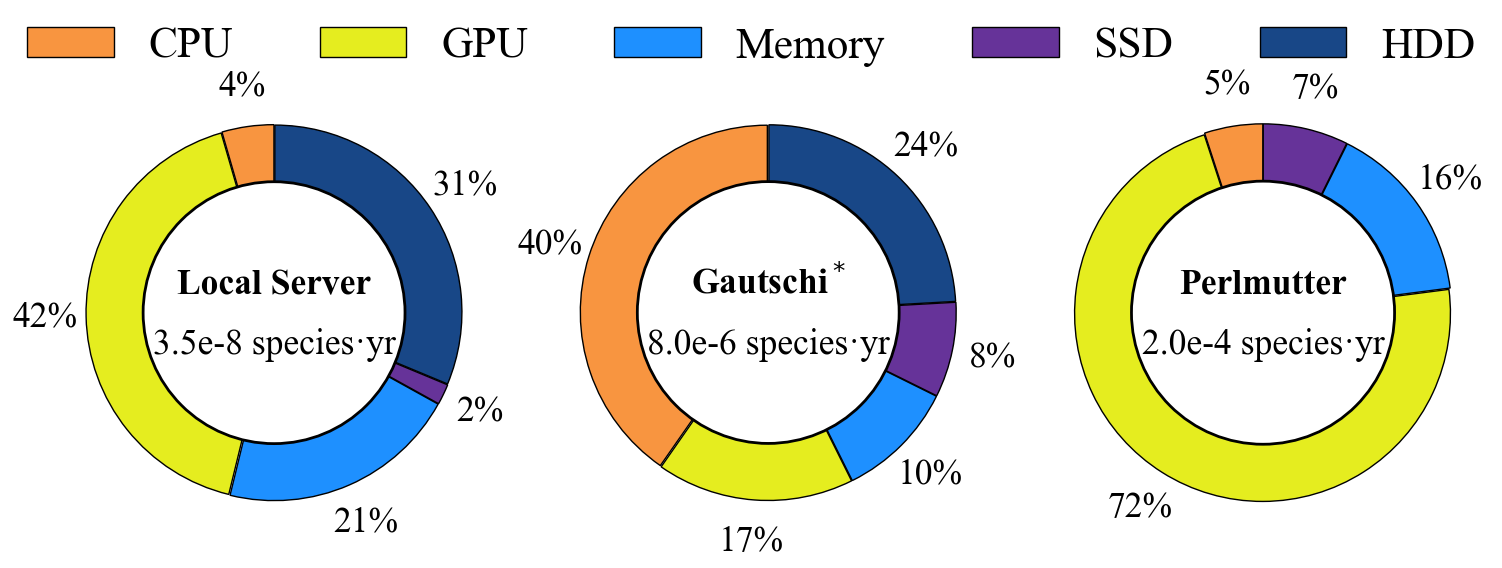

In [ ]:
# Get impact ratios for L40 server
l40_server_ratios = calculate_impact_ratios(server_specs, impacts)

# Calculate Perlmutter component distribution
perlmutter_total_endpoint = sum(perl_endpoint_impacts.values())

# Calculate component impacts for Perlmutter
total_cpu_impacts = 0
total_gpu_impacts = 0  
total_memory_impacts = 0
total_storage_impacts = 0

# CPU impacts
for cpu in range(len(perlmutter_specs['cpu_nodes']['cpus']) + len(perlmutter_specs['gpu_nodes']['cpus'])):
    cpu_impact = calculate_total_impact(epyc_7b13_specs)
    total_cpu_impacts += sum(cpu_impact['total']['endpoint'].values())

# Memory impacts    
for node in range(len(perlmutter_specs['cpu_nodes']['cpus'])):
    mem_specs = {
        'component_type': 'DRAM',
        'capacity': perlmutter_specs['cpu_nodes']['ram_per_node'],
        'production_year': 2021,
        'distance': distance['default']
    }
    mem_impact = calculate_total_impact(mem_specs)
    total_memory_impacts += sum(mem_impact['total']['endpoint'].values())

for node in range(len(perlmutter_specs['gpu_nodes']['cpus'])):
    mem_specs = {
        'component_type': 'DRAM', 
        'capacity': perlmutter_specs['gpu_nodes']['ram_per_node'],
        'production_year': 2021,
        'distance': distance['default']
    }
    mem_impact = calculate_total_impact(mem_specs)
    total_memory_impacts += sum(mem_impact['total']['endpoint'].values())

# GPU impacts
for node in range(len(perlmutter_specs['gpu_nodes']['gpus'])):
    gpu_impact = calculate_total_impact(a100_80g_specs)
    total_gpu_impacts += sum(gpu_impact['total']['endpoint'].values()) * 4

for node in range(len(perlmutter_specs['gpu_nodes']['gpus2'])):
    gpu_impact = calculate_total_impact(a100_40g_specs)
    total_gpu_impacts += sum(gpu_impact['total']['endpoint'].values()) * 4

# Storage impacts
storage_specs = {
    'component_type': perlmutter_specs['storage']['type'],
    'capacity': perlmutter_specs['storage']['capacity'],
    'production_year': 2021, 
    'distance': distance['default']
}
storage_impact = calculate_total_impact(storage_specs)
total_storage_impacts += sum(storage_impact['total']['endpoint'].values())

# Calculate percentages
perlmutter_ratios = {
    'CPU': total_cpu_impacts / perlmutter_total_endpoint * 100, 
    'GPU': total_gpu_impacts / perlmutter_total_endpoint * 100,
    'Memory': total_memory_impacts / perlmutter_total_endpoint * 100,
    'SSD': total_storage_impacts / perlmutter_total_endpoint * 100,
    'HDD': 0  # No HDD in Perlmutter
}

# Calculate gaustchi impacts based on components
gaustchi_total_endpoint = sum(gau_endpoint_impacts.values())

# Initialize component impacts
total_cpu_impacts = 0
total_gpu_impacts = 0
total_memory_impacts = 0
total_ssd_impacts = 0
total_hdd_impacts = 0

# CPU impacts from all nodes
for node in range(len(gautschi_specs['cpu_nodes']['cpus'])):
    cpu_impact = calculate_total_impact(epyc_9b14_specs)
    total_cpu_impacts += sum(cpu_impact['total']['endpoint'].values())

# High memory nodes
for node in range(len(gautschi_specs['special_nodes']['high_mem_nodes']['cpus'])):
    cpu_impact = calculate_total_impact(gautschi_specs['special_nodes']['high_mem_nodes']['cpus'][node])
    total_cpu_impacts += sum(cpu_impact['total']['endpoint'].values())
    
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': gautschi_specs['special_nodes']['high_mem_nodes']['ram_per_node'],
        'production_year': 2023,
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    total_memory_impacts += sum(memory_impact['total']['endpoint'].values())

# Database nodes
for node in range(len(gautschi_specs['special_nodes']['db_nodes']['cpus'])):
    cpu_impact = calculate_total_impact(gautschi_specs['special_nodes']['db_nodes']['cpus'][node])
    total_cpu_impacts += sum(cpu_impact['total']['endpoint'].values())
    
    memory_specs = {
        'component_type': 'DRAM',
        'capacity': gautschi_specs['special_nodes']['db_nodes']['ram_per_node'],
        'production_year': 2023,
        'distance': distance['default']
    }
    memory_impact = calculate_total_impact(memory_specs)
    total_memory_impacts += sum(memory_impact['total']['endpoint'].values())

# GPU nodes - H100
for gpu in gautschi_specs['gpu_nodes']['h100_nodes']['gpus']:
    gpu_impact = calculate_total_impact(h100_specs)
    total_gpu_impacts += sum(gpu_impact['total']['endpoint'].values())

# GPU nodes - L40 
for gpu in gautschi_specs['gpu_nodes']['l40_nodes']['gpus']:
    gpu_impact = calculate_total_impact(l40_specs)
    total_gpu_impacts += sum(gpu_impact['total']['endpoint'].values())

# Storage impacts
for storage in gautschi_specs['storage']:
    storage_specs = {
        'component_type': storage['type'],
        'capacity': storage['capacity'], 
        'production_year': 2023,
        'distance': distance['default']
    }
    storage_impact = calculate_total_impact(storage_specs)
    if storage['type'] == 'SSD':
        total_ssd_impacts += sum(storage_impact['total']['endpoint'].values())
    else:
        total_hdd_impacts += sum(storage_impact['total']['endpoint'].values())

# Calculate ratios
gautschi_ratios = {
    'CPU': total_cpu_impacts / gaustchi_total_endpoint * 100,
    'GPU': total_gpu_impacts / gaustchi_total_endpoint * 100,
    'Memory': total_memory_impacts / gaustchi_total_endpoint * 100,
    'SSD': total_ssd_impacts / gaustchi_total_endpoint * 100,
    'HDD': total_hdd_impacts / gaustchi_total_endpoint * 100
}

ratios_list = [l40_server_ratios, gautschi_ratios, perlmutter_ratios ] 
titles = ['Local Server', 'Gautschi$^*$','Perlmutter']
total_endpoint_impacts = [3.54e-8, 8.02e-6, 2e-4,]  # species·yr


fig, axes = plot_system_impact_donuts(ratios_list, titles)
for ax, total_impact in zip(axes, total_endpoint_impacts):
    # Add total impact text
    ax.text(0, -0.17, f'{total_impact:.1e} species·yr'.replace('e-0', 'e-'), fontsize=FONTSIZE/1.25, ha='center', va='center', color='black')
# plt.savefig('../../figures/system_impact_comparison.pdf', bbox_inches='tight')
plt.show()


In [20]:
electricity_mix = {
    'CA': {
        'Hydro': 0.0957,
        'Solar': 0.2135,
        'Wind': 0.0110,
        'Gas': 0.2749,
        'Nuclear': 0.0772,
        'Biomass': 0.0162,
        'Geothermal': 0.0281,
    },
    'MISO': {
        'Hydro': 0.0157,
        'Solar': 0.0211,
        'Wind': 0.1434,
        'Nuclear': 0.1324,
        'Coal': 0.2435,
        'Gas': 0.3717,
    },
    'QC': {
        'Hydro': 0.9905,
        'Wind': 0.0043,
        'Gas': 0.0022,
        'Oil': 0.0029
    },
    'Taiwan': {
        'Hydro': 0.0165,
        'Solar': 0.0657,
        'Wind': 0.00375,
        'Nuclear': 0.0465,
        'Biomass': 0.00008,
        'Coal': 0.3128,
        'Gas': 0.5057,
        'Oil': 0.0128
    }
}

color_map = {
    'Hydro': '#4591EB',
    'Solar': '#FED030',
    'Wind': '#86DCF6',
    'Gas': '#BBB3A0',
    'Nuclear': '#B08BF6',
    'Biomass': '#008043',
    'Geothermal': '#A73C15',
    'Coal': '#757474',
    'Oil': '#796B68'
}

emission_factors = {
    'CO2': {
        'US Mean': 771.5* 0.45359237 /1000,
        'CA': 0.231,  # kg CO2/kWh
        'MISO': 0.485,
        'QC': 0.035,
        'Taiwan': 0.525
    },
    'SOx': {
        'US Mean': unified_emission_factors['SOx']['US'][-1],  # g SOx/kWh
        'CA': unified_emission_factors['SOx']['CA'][-1],  # g SOx/kWh
        'MISO': unified_emission_factors['SOx']['MidWest'][-1],
        'QC': unified_emission_factors['SOx']['MidWest'][-1]/((0.2435+0.3717)/0.005),
        'Taiwan': unified_emission_factors['SOx']['Taiwan_g/kWh_report'][-1]
    },
    'NOx': {
        'US Mean': unified_emission_factors['NOx']['US'][-1],  # g NOx/kWh
        'CA': unified_emission_factors['NOx']['CA'][-1],  # g NOx/kWh
        'MISO': unified_emission_factors['NOx']['MidWest'][-1],
        'QC': unified_emission_factors['NOx']['MidWest'][-1]/((0.2435+0.3717)/0.005),
        'Taiwan': unified_emission_factors['NOx']['Taiwan_g/kWh_report'][-1]
    },
}

emission_standards = {
    'SOx': {
        'USA': 0.635,
        'China': 0.048,
        'Taiwan': 0.108
    },
    'NOx': {
        'USA': 0.454,
        'China': 0.069,
        'Taiwan': 0.180
    }
}

# Normalize specified regions so their mixes sum to 1
for region in ['MISO', 'CA', 'Taiwan']:
    total = sum(electricity_mix[region].values())
    electricity_mix[region] = {
        source: share / total
        for source, share in electricity_mix[region].items()
    }

# Optional check
print({r: sum(electricity_mix[r].values()) for r in ['MISO', 'CA', 'Taiwan']})

{'MISO': 1.0, 'CA': 1.0, 'Taiwan': 1.0}


In [21]:

# Calculate embodied impacts 
embodied_endpoint = sum(perl_endpoint_impacts.values())

# Calculate operational impacts for each region
operational_impacts = {}
regions = ['US Mean','CA', 'MISO', 'Taiwan', 'QC']

# Calculate annual energy consumption
tdp_7b13 = epyc_7b13_specs['TDP'] 
tdp_a100_40g = a100_40g_specs['TDP']
tdp_a100_80g = a100_80g_specs['TDP']

total_cpu_power = tdp_7b13 * (1536 + 256 + 3072*2)  # All CPU nodes
total_gpu_power = tdp_a100_40g * 6144 + tdp_a100_80g * 1024  # All GPUs

total_power = (total_cpu_power + total_gpu_power) * 1.2  # Adding 20% overhead for memory, storage and cooling
total_power *= 0.5  # Assuming 50% load factor
annual_energy = total_power * 24 * 365 / 1000  # kWh per year

# Calculate impacts for each region
for region in regions:
    sox_ef = emission_factors['SOx'][region]  # g/kWh
    nox_ef = emission_factors['NOx'][region]  # g/kWh
    nh3_ef = unified_emission_factors['NH3']['US'][-1] if region != 'QC' else 0  # g/kWh, assumed same for US grids
    
    # Calculate operational impacts (kg)
    impacts = {
        'AP': (sox_ef * impact_factors['AP']['SOx'] + 
               nox_ef * impact_factors['AP']['NOx'] + 
               nh3_ef * impact_factors['AP']['NH3']) * annual_energy / 1000,
        'EP': (nox_ef * impact_factors['EP']['NOx'] + 
               nh3_ef * impact_factors['EP']['NH3']) * annual_energy / 1000,
        'FETox': 0  # Assuming negligible direct ecotoxicity impact
    }
    
    # Convert to endpoint
    operational_impacts[region] = sum(midpoint_to_endpoint(impacts).values())

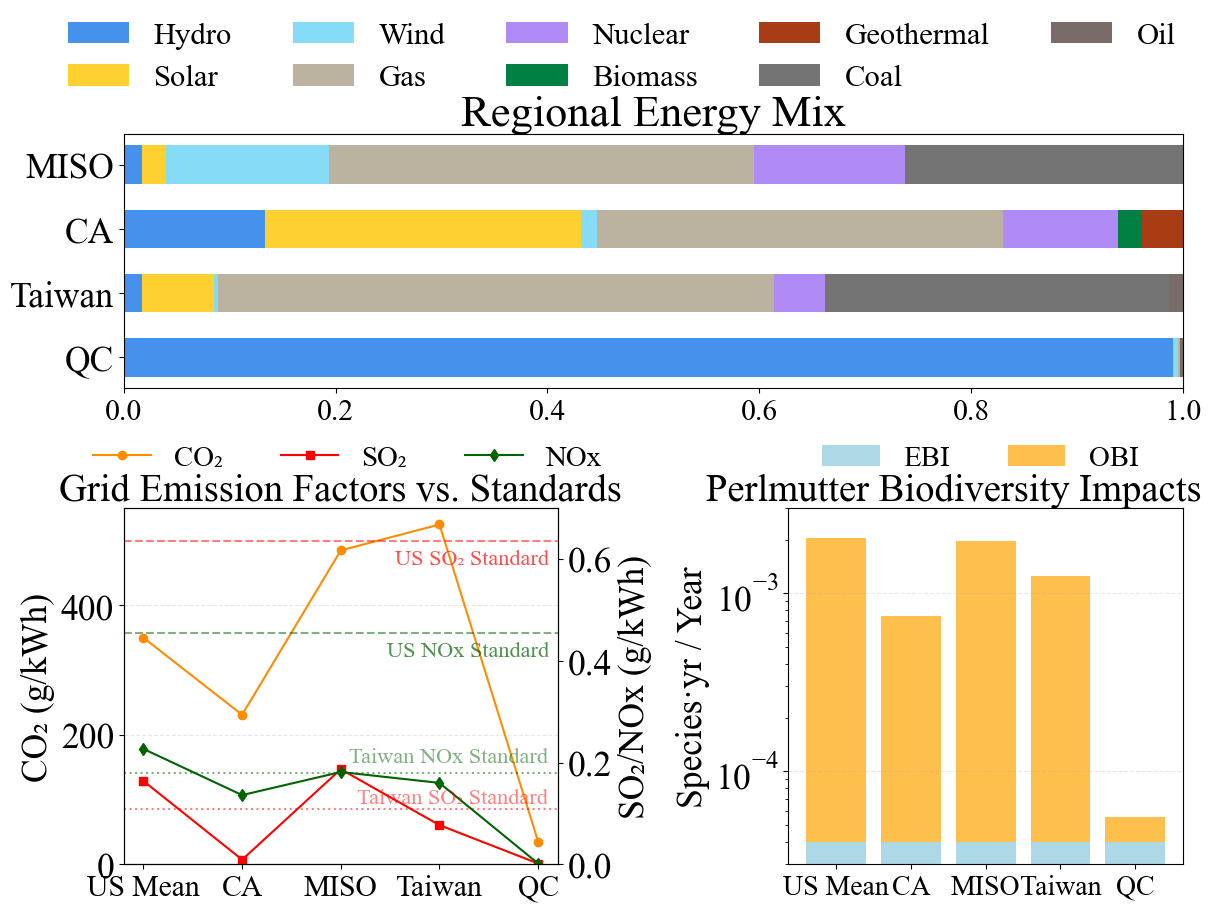

In [36]:

# First row: energy mix
regions_emix = ['MISO', 'CA', 'Taiwan', 'QC']
y_emix = np.arange(len(regions_emix), 0, -1)
fig = plt.figure(constrained_layout=True, figsize=(12, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.4], width_ratios=[1.1, 1])

ax_top = fig.add_subplot(gs[0, :])
left = np.zeros(len(regions_emix))
for source, color in color_map.items():
    vals = np.array([electricity_mix[r].get(source, 0) for r in regions_emix])
    if vals.any():
        ax_top.barh(y_emix, vals, left=left, height=0.6,
                    color=color, label=source)
        left += vals
ax_top.set_xlim(0, 1)
ax_top.set_yticks(y_emix)
ax_top.set_yticklabels(regions_emix, fontsize=FONTSIZE/1.25)
ax_top.set_title('Regional Energy Mix', fontsize=FONTSIZE)
ax_top.legend(ncol=5, bbox_to_anchor=(0.47, 1.55), loc='upper center', frameon=False,fontsize=LEGEND_FONTSIZE/1.18)
ax_top.tick_params(axis='x', labelsize=FONTSIZE/1.5)

# Second row left: emissions factors
ax_left = fig.add_subplot(gs[1, 0])
regions_ops = ['US Mean', 'CA', 'MISO', 'Taiwan', 'QC']
x_ops = np.arange(len(regions_ops))

# CO2 (g/kWh)
co2_vals = [emission_factors['CO2'][r] * 1000 for r in regions_ops]
ax_left.plot(x_ops, co2_vals, 'o-', color='darkorange', label='CO₂')

# SOx and NOx on twin axis
ax2 = ax_left.twinx()
sox_vals = [emission_factors['SOx'][r] for r in regions_ops]
nox_vals = [emission_factors['NOx'][r] for r in regions_ops]
ax2.plot(x_ops, sox_vals, 's-', color='red', label='SO₂')
ax2.plot(x_ops, nox_vals, 'd-', color='darkgreen', label='NOx')

# standards lines
ax2.axhline(emission_standards['SOx']['USA'], linestyle='--', color='red', alpha=0.5)
ax2.axhline(emission_standards['NOx']['USA'], linestyle='--', color='darkgreen', alpha=0.5)
ax2.axhline(emission_standards['SOx']['Taiwan'], linestyle=':', color='red', alpha=0.5)
ax2.axhline(emission_standards['NOx']['Taiwan'], linestyle=':', color='darkgreen', alpha=0.5)

ax_left.set_xticks(x_ops)
ax_left.set_xticklabels(regions_ops, fontsize=FONTSIZE/1.5)
ax_left.set_ylabel('CO₂ (g/kWh)', fontsize=FONTSIZE/1.25)
ax2.set_ylabel('SO₂/NOx (g/kWh)', fontsize=FONTSIZE/1.25)
ax_left.set_title('Grid Emission Factors vs. Standards', fontsize=FONTSIZE/1.15)
lines, labels = ax_left.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax_left.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False, fontsize=LEGEND_FONTSIZE/1.25, ncol=3, bbox_to_anchor=(-0.13,1.25))
ax_left.grid(axis='y', linestyle='--', alpha=0.3)
ax_left.tick_params(axis='y', labelsize=FONTSIZE/1.25)
ax2.set_yticks([0, 0.2, 0.4, 0.6])
ax2.tick_params(axis='y', labelsize=FONTSIZE/1.25)
ax2.set_ylim(0, 0.7)
ax_left.set_ylim(0, 550)

ax2.annotate('US SO₂ Standard', xy=(0, emission_standards['SOx']['USA']), xytext=(2.55, 0.59),
            fontsize=FONTSIZE/2, color='red',alpha=0.7)
ax2.annotate('US NOx Standard', xy=(0, emission_standards['NOx']['USA']), xytext=(2.47, 0.41),
            fontsize=FONTSIZE/2, color='darkgreen',alpha=0.7)
ax2.annotate('Taiwan SO₂ Standard', xy=(0, emission_standards['SOx']['Taiwan']), xytext=(2.16, 0.12),
            fontsize=FONTSIZE/2, color='red',alpha=0.5)
ax2.annotate('Taiwan NOx Standard', xy=(0, emission_standards['NOx']['Taiwan']), xytext=(2.08, 0.2),
            fontsize=FONTSIZE/2, color='darkgreen',alpha=0.5)


# Second row right: annual impacts
ax_right = fig.add_subplot(gs[1, 1])
man = embodied_endpoint / 5
# trans = 0.01 * man
ops = [operational_impacts[r] for r in regions_ops]

bottom = np.zeros(len(regions_ops))
ax_right.bar(x_ops, [man]*len(regions_ops), label='EBI', color='lightblue')
bottom += man
# ax_right.bar(x_ops, [trans]*len(regions_ops), bottom=bottom,
#              label='Transport', color='lightgreen')
# bottom += trans
ax_right.bar(x_ops, ops, bottom=bottom,
             label='OBI', color='orange',alpha=0.7)

ax_right.set_xticks(x_ops)
ax_right.set_xticklabels(regions_ops, fontsize=FONTSIZE/1.6)
ax_right.set_ylabel('Species·yr / Year', fontsize=FONTSIZE/1.25)
ax_right.tick_params(axis='y', labelsize=FONTSIZE/1.25)
ax_right.set_title('Perlmutter Biodiversity Impacts', fontsize=FONTSIZE/1.15,x=0.42)
ax_right.legend(frameon=False,fontsize=LEGEND_FONTSIZE/1.25, loc='upper left', bbox_to_anchor=(0.02, 1.25), ncol=2)
ax_right.grid(axis='y', linestyle='--', alpha=0.3)
ax_right.set_yscale('log')
ax_right.set_ylim(3e-5, 3e-3)

plt.savefig('../../figures/spatial.pdf', bbox_inches='tight')
plt.show()

## Computing Workloads
### List of HPC benchmarks
Use normalized throughput as performance metric. (EPYC 7443=1)

1. Single core compression and decompression
- pts/compress-lz4-1.10.0        LZ4 Compression         level 12 (max)      
pts/compress-xz-1.1.0             XZ Compression         default level    
pts/compress-lzma               lzma compression         default level    
pts/compress-zstd               zstd compression         level 19 (max)    
pts/compress-gzip               gzip compression         default level    
pts/system-decompress-bzip2-1.0.2 System BZIP2 Decompression       
pts/system-decompress-gzip-1.1.1  System GZIP Decompression       
pts/system-decompress-zlib-1.0.2  System ZLIB Decompression 

2. Multi-core compression
- pts/compress-pbzip2-1.6.1         Parallel BZIP2 Compression      

3. Single-core FFT
- pts/fftw-1.2.0                    FFTW                 

4. Multi-core computation suites     
- pts/npb-1.4.5                     NAS Parallel Benchmarks   
- pts/openssl-3.3.0                 OpenSSL          Encrption, all cores all threads             
- pts/spark-1.0.1                   Apache Spark     Big Data MapReduce             
 
5. Video and Image encoding / decoding
- pts/x264-2.7.0                    x264              video encoding, 8 cores            
pts/x265-1.5.0                    x265                                 
pts/jpegxl-1.6.0                  JPEG-XL libjxl                
pts/jpegxl-decode-1.6.0           JPEG-XL Decoding libjxl       

6. Compiling Timed test
- pts/build-llvm   
pts/build-linux-kernel

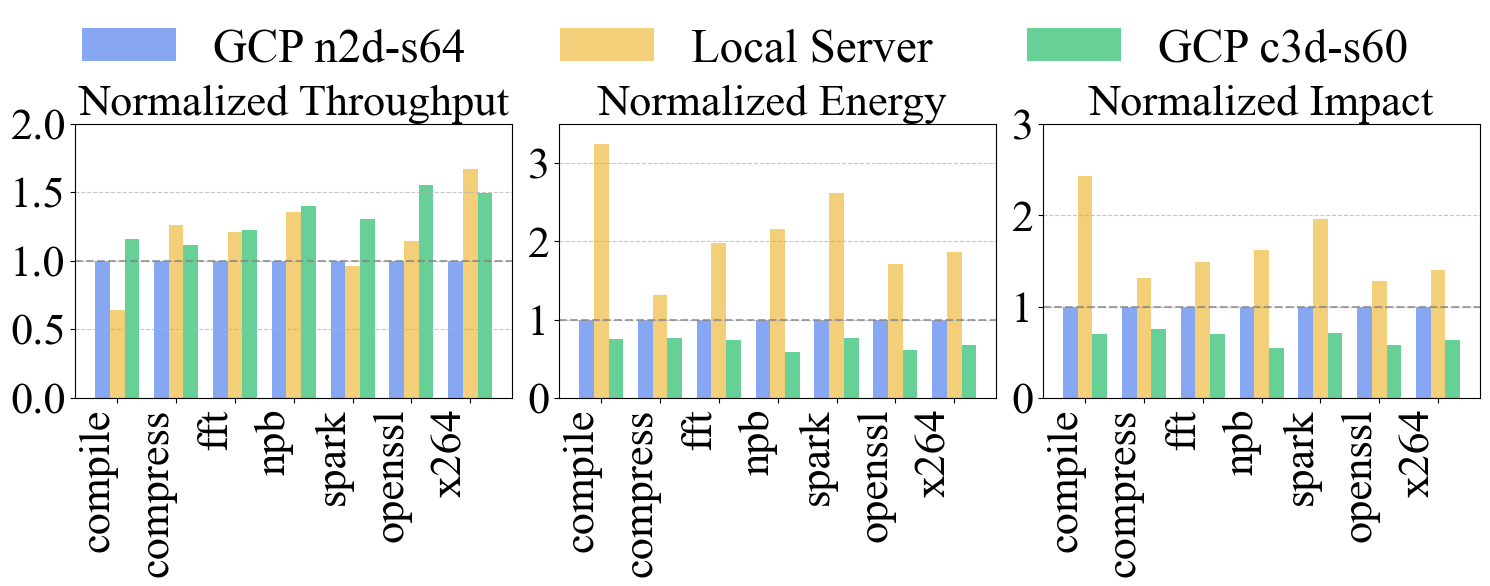

In [32]:
from process_hpc_results import *
# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
# fig.suptitle('Performance, Energy, and Environmental Impact Comparison', fontsize=16)

# Width of each bar
width = 0.25
x = np.arange(len(selected_tests))

# Colors for each system
colors = [ '#87a7f2','#f3cf79', '#67d097']  # blue, orange, green

# Plot Normalized Throughput
axes[0].set_title('Normalized Throughput', fontsize=FONTSIZE)
axes[0].bar(x - width, normalized_throughputs['EPYC 7B12'], width, label='GCP n2d-s64', color=colors[0])
axes[0].bar(x, normalized_throughputs['EPYC 7443'], width, label='Local Server', color=colors[1])
axes[0].bar(x + width, normalized_throughputs['EPYC 9B14'], width, label='GCP c3d-s60', color=colors[2])
# axes[0].set_ylabel('Relative Performance', fontsize=FONTSIZE/1.25)
axes[0].set_xticks(x)
axes[0].set_xticklabels(selected_tests, rotation=90, ha='right')
axes[0].tick_params(axis='y', which='major', labelsize=FONTSIZE)
axes[0].tick_params(axis='x', which='major', labelsize=FONTSIZE)
axes[0].set_ylim(0, 2.0)
axes[0].set_yticks([0, 0.5, 1, 1.5, 2])
axes[0].axhline(y=1.0, linestyle='--', color='gray', alpha=0.7)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Normalized Energy Ratio
axes[1].set_title('Normalized Energy ', fontsize=FONTSIZE)
axes[1].bar(x - width, normalized_energy_ratio['EPYC 7B12'], width, label='EPYC 7B12', color=colors[0])
axes[1].bar(x, normalized_energy_ratio['EPYC 7443'], width, label='EPYC 7443', color=colors[1])
axes[1].bar(x + width, normalized_energy_ratio['EPYC 9B14'], width, label='EPYC 9B14', color=colors[2])
# axes[1].set_ylabel('Relative Energy Use', fontsize=FONTSIZE/1.25)
axes[1].set_xticks(x)
axes[1].set_xticklabels(selected_tests, rotation=90, ha='right')
axes[1].set_ylim(0, 3.5)
axes[1].set_yticks([0, 1, 2, 3])
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axes[1].axhline(y=1.0, linestyle='--', color='gray', alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Normalized Environmental Impact
axes[2].set_title('Normalized Impact', fontsize=FONTSIZE)
axes[2].bar(x - width, normalized_impacts['EPYC 7B12'], width, label='EPYC 7B12', color=colors[0])
axes[2].bar(x, normalized_impacts['EPYC 7443'], width, label='EPYC 7443', color=colors[1])
axes[2].bar(x + width, normalized_impacts['EPYC 9B14'], width, label='EPYC 9B14', color=colors[2])
# axes[2].set_ylabel('Relative Biodiversity Impact', fontsize=FONTSIZE/1.25)
axes[2].set_xticks(x)
axes[2].set_xticklabels(selected_tests, rotation=90, ha='right')
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axes[2].set_ylim(0, 3.0)
axes[2].axhline(y=1.0, linestyle='--', color='gray', alpha=0.7)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=LEGEND_FONTSIZE*1.3, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
# plt.savefig('figures/hpc_results.pdf', bbox_inches='tight')
plt.show()